# NBA Scores
**ML Project 1 - Spring 2022**

Collaborators: Ben DeSollar and Matt McDonell

### Step 1
Import the required packages and frameworks.

In [1]:
# imports
import numpy as np
from mlwpy import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from sklearn import (datasets, neighbors,
                     naive_bayes,
                     model_selection as skms,
                     linear_model, dummy,
                     metrics,
                     pipeline,
                     preprocessing as skpre) 
import csv
from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Step 2
Read in the .csv files and create DataFrames

In [2]:
data_train_df = pd.read_csv("train.csv") 
test_df = pd.read_csv("test.csv")
data_train_ft = data_train_df.drop('PTS', axis=1)
data_train_tgt = data_train_df["PTS"]

### Step 3
Focus down to the features we think will have the largest impact on points scored.

In [3]:
features = ['BIRTHDATE',\
            'SEASON_EXP',
            'HEIGHT',
            'WEIGHT',
            'AST',
            'REB',
            'ALL_STAR_APPEARANCES',
            ]

# To see what kind of data we're working with
# print(data_train_ft.dtypes)

### Step 4
Convert numbers to their correct formats and fill in any missing values.

In [4]:
#### Training Data
data_train_ft['BIRTHDATE'] = pd.to_datetime(data_train_ft['BIRTHDATE'])
data_train_ft['BIRTHDATE'] = 2022 - pd.DatetimeIndex(data_train_ft['BIRTHDATE']).year 

data_train_ft['BIRTHDATE'] = data_train_ft['BIRTHDATE'].astype(float)
data_train_ft['SEASON_EXP'] = data_train_ft['SEASON_EXP'].astype(float)

#print(data_train_ft['BIRTHDATE'])
pd.set_option('precision', 2)
#print(data_train_ft.describe())

data_train_ft['SEASON_EXP'] = data_train_ft['SEASON_EXP'].fillna(0)
data_train_ft['BIRTHDATE'] = data_train_ft['BIRTHDATE'].fillna(0)
data_train_ft['AST'] = data_train_ft['AST'].fillna(0)
data_train_ft['REB'] = data_train_ft['REB'].fillna(0)
data_train_ft['ALL_STAR_APPEARANCES'] = data_train_ft['ALL_STAR_APPEARANCES'].fillna(0)
data_train_ft['HEIGHT'] = data_train_ft['HEIGHT'].fillna(0)
data_train_ft['WEIGHT'] = data_train_ft['WEIGHT'].fillna(0)
data_train_ft = data_train_ft[features]
# data_train_ft['DRAFT_ROUND'].astype(int)


#### Testing Data
test_df['BIRTHDATE'] = pd.to_datetime(test_df['BIRTHDATE'])
test_df['BIRTHDATE'] = 2022 - pd.DatetimeIndex(test_df['BIRTHDATE']).year 

test_df['BIRTHDATE'] = test_df['BIRTHDATE'].astype(float)
test_df['SEASON_EXP'] = test_df['SEASON_EXP'].astype(float)

test_df['SEASON_EXP'] = test_df['SEASON_EXP'].fillna(0)
test_df['BIRTHDATE'] = test_df['BIRTHDATE'].fillna(0)
test_df['AST'] = test_df['AST'].fillna(0)
test_df['REB'] = test_df['REB'].fillna(0)
test_df['ALL_STAR_APPEARANCES'] = data_train_ft['ALL_STAR_APPEARANCES'].fillna(0)
test_df['HEIGHT'] = test_df['HEIGHT'].fillna(0)
test_df['WEIGHT'] = test_df['WEIGHT'].fillna(0)
test_df = test_df[features]

### Step 5
Create a heat map to visualize trends present in the data.

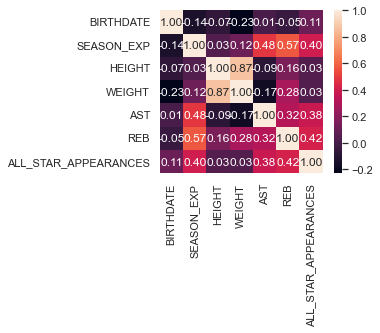

In [5]:
correlation_map = np.corrcoef(data_train_ft.values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=features, xticklabels=features)

plt.show()

### Step 6
Split the data into training and validation sets for use with cross-validation scoring.

In [6]:
train_plus_validation_ftrs, test_ftrs, train_plus_validation_tgt, test_tgt = train_test_split (data_train_ft, data_train_tgt, test_size = 0.20,
                                   random_state = 42)

### Step 7
Using different standardizing pipelines, run multiple cross-validation tests on the data splits to find the best performing model.

In [7]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
for k in range(1,32,2):
    pipelines.append((f'ScaledKNN-{k}', Pipeline([('Scaler', StandardScaler()),(f'KNN-{k}', KNeighborsRegressor(n_neighbors=k))])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, train_plus_validation_ftrs, train_plus_validation_tgt, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -6.672158 (0.951973)
ScaledLASSO: -8.411187 (1.235133)
ScaledEN: -8.496856 (1.250486)
ScaledKNN-1: -8.653948 (1.521456)
ScaledKNN-3: -5.682438 (0.783832)
ScaledKNN-5: -5.330744 (1.018002)
ScaledKNN-7: -5.134970 (0.954137)
ScaledKNN-9: -5.062312 (0.838261)
ScaledKNN-11: -5.014162 (0.844301)
ScaledKNN-13: -5.073044 (0.828663)
ScaledKNN-15: -5.062845 (0.835755)
ScaledKNN-17: -5.086189 (0.792254)
ScaledKNN-19: -5.123270 (0.830200)
ScaledKNN-21: -5.130081 (0.829096)
ScaledKNN-23: -5.176501 (0.812951)
ScaledKNN-25: -5.205808 (0.812767)
ScaledKNN-27: -5.254445 (0.802504)
ScaledKNN-29: -5.323071 (0.800918)
ScaledKNN-31: -5.402680 (0.801008)
ScaledCART: -9.340841 (1.284499)
ScaledGBM: -4.770113 (0.730035)


### Step 8
Further refine the selection of best model by comparing standardization test scores.

In [8]:
scaler = StandardScaler().fit(train_plus_validation_ftrs)
rescaledX = scaler.transform(train_plus_validation_ftrs)
param_grid = dict(n_estimators=np.array([50,100,150,200,300,400]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, train_plus_validation_tgt)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-4.858495 (0.719092) with: {'n_estimators': 50}
-4.782325 (0.719604) with: {'n_estimators': 100}
-4.767227 (0.726746) with: {'n_estimators': 150}
-4.755234 (0.725986) with: {'n_estimators': 200}
-4.792584 (0.701359) with: {'n_estimators': 300}
-4.857803 (0.717516) with: {'n_estimators': 400}
Best: -4.755234 using {'n_estimators': 200}


### Step 9
Rescale the data and fit the model using a Gradient Boosting Regressor approach.

In [9]:
scaler = StandardScaler().fit(train_plus_validation_ftrs)
rescaled_train_plus_validation_ftrs = scaler.transform(train_plus_validation_ftrs)
model = GradientBoostingRegressor(random_state=21, n_estimators=400)
model.fit(rescaled_train_plus_validation_ftrs, train_plus_validation_tgt)

GradientBoostingRegressor(n_estimators=400, random_state=21)

### Step 10
Using the newly scaled data, predict points on the selected model and save it in a temporary .csv for analysis.

In [10]:
rescaled_test_ftrs = scaler.transform(test_df)
predictions = model.predict(rescaled_test_ftrs)

# compare = pd.DataFrame({'Prediction': predictions, 'Test Data' : test_tgt})
# compare.head(10)
# This is just using the test.csv to setup a dataframe of the correct size
# and indicies (the "id" field).
make_submission_df = pd.read_csv("test.csv")
# drop all columns except 'id'
make_submission_df = make_submission_df[['id']]
# make sure the column of ID's that we just read in is the index column
make_submission_df = make_submission_df.set_index('id')

### Step 11
Add our predictions to a submission file and save the final .csv

In [11]:
make_submission_df['PTS'] = predictions
make_submission_df.to_csv('submission.csv',sep=',', float_format='%.2f')